# 1. Setup Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

# 2. Setup the Qdrant vector database

In [2]:
import qdrant_client

collection_name = "chat_with_docs_docling"

client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333,
)

/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 3. Read the documents

Convert to markdown using Docling

In [3]:
import os
from glob import glob
from pathlib import Path

from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem


pdf_dir = "./docs"
pdf_files = glob(os.path.join(pdf_dir, "*.pdf"))
md_files = []

IMAGE_RESOLUTION_SCALE = 2.0
output_dir = Path("processed_docs")
output_dir.mkdir(parents=True, exist_ok=True)

# Pipeline options for PDF conversion
pipeline_options = PdfPipelineOptions(do_table_structure=True)
# Table options
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model
# Image options
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_picture_images = True
pipeline_options.generate_page_images = True        # This is needed to generate table images

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

def replace_artifact_images(md_path, doc_filename):
    import re

    """
    Replace image links to _artifacts with links to your own saved images.
    """
    md_text = Path(md_path).read_text()
    # Replace artifact image links with your own pictures/picture-{n}.png
    # Example: ![](docling_artifacts/image_000000_abc123.png) -> ![](docling/pictures/picture-1.png)
    artifact_img_regex = re.compile(r'!\[.*?\]\((?:.*?_artifacts/)?image_\d+_[a-f0-9]+\.png\)')
    picture_idx = 1

    def replacer(match):
        nonlocal picture_idx
        new_link = f"![]({doc_filename}/pictures/picture-{picture_idx}.png)"
        picture_idx += 1
        return new_link

    return artifact_img_regex.sub(replacer, md_text)

# Convert each PDF to Markdown using Docling's Python API
ddocs = []
for pdf_path in pdf_files:
    result = converter.convert(pdf_path)
    ddocs.append(result.document)

    # Save images of figures and tables
    doc_filename = result.input.file.stem
    table_counter = 0
    picture_counter = 0

    # Need to create document directories for images and tables
    (output_dir / doc_filename / "tables").mkdir(parents=True, exist_ok=True)
    (output_dir / doc_filename / "pictures").mkdir(parents=True, exist_ok=True)

    for element, _level in result.document.iterate_items():
        if isinstance(element, TableItem):
            table_counter += 1
            element_image_filename = (
                output_dir / doc_filename / "tables" / f"table-{table_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(result.document).save(fp, "PNG")

        if isinstance(element, PictureItem):
            picture_counter += 1
            element_image_filename = (
                output_dir / doc_filename / "pictures" / f"picture-{picture_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(result.document).save(fp, "PNG")

    # Save markdown with externally referenced pictures
    md_filename = output_dir / f"{doc_filename}.md"
    result.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

    # Replace artifact image links with your own pictures/picture-{n}.png
    md_text = replace_artifact_images(md_filename, doc_filename)
    md_filename.write_text(md_text)

    # Cleanup up artifacts directory if it exists
    artifacts_dir = output_dir / f"{doc_filename}_artifacts"
    if artifacts_dir.exists():
        import shutil
        shutil.rmtree(artifacts_dir)

/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## Inspecting Docling Documents

[PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=261.96795654296875, t=715.9161758422852, r=348.657958984375, b=627.1296234130859, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=173.0, height=178.0), uri=AnyUrl('')), annotations=[]),
 PictureItem(self_ref='#/pictures/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/31'), RefItem(cref='#/texts/32'), RefItem(cref='#/texts/33'), RefItem(cref='#/texts/34'), RefItem(cref='#/texts/35'), RefItem(cref='#/texts/36'), RefItem(cref='#/texts/37'), RefItem(cref='#/texts/38'), RefItem(cref='#/texts/39'), RefItem(cref='#/texts/40'), RefItem(cref='#/texts/41'), RefItem(cref='#/texts/42'), RefItem(cref='#/texts/43'), RefItem(cref='#/texts/44'
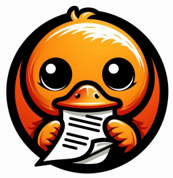
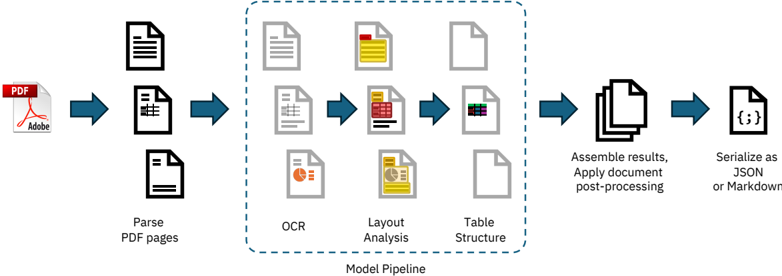
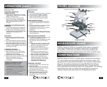
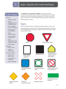
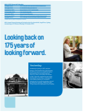
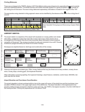
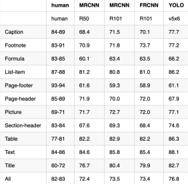
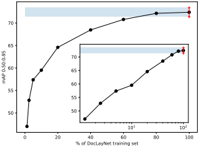
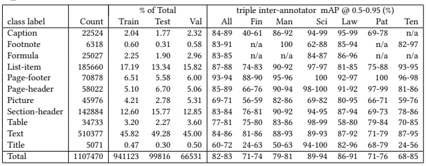
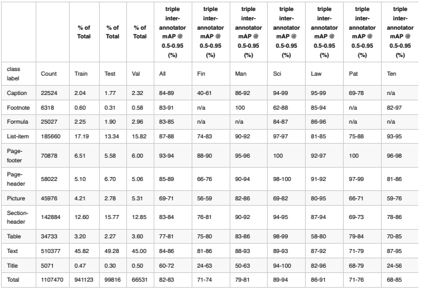
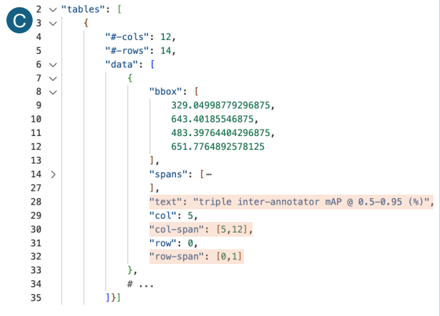

In [4]:
ddoc = ddocs[0]  # Use the first document for indexing
ddoc.pictures

In [5]:
ddoc.origin.filename

'docling.pdf'

In [6]:
image = ddoc.pictures[1]
provenance = image.prov[0]
provenance

ProvenanceItem(page_no=3, bbox=BoundingBox(l=110.07231140136719, t=719.2913360595703, r=500.7577209472656, b=581.2926177978516, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))

In [7]:
import fitz  # PyMuPDF

def save_image_from_provenance(pdf_path, provenance, output_path):
    """
    Extracts and saves an image from a PDF using provenance info.
    provenance should have 'page_ix' (0-based) and 'bbox' ([x0, y0, x1, y1])
    """
    page_ix = provenance.page_no-1  # Convert to 0-based index
    doc = fitz.open(pdf_path)
    page = doc[page_ix]

    _bbox = provenance.bbox.to_top_left_origin(page_height=page.rect.height)
    bbox = [_bbox.l, _bbox.t, _bbox.r, _bbox.b]  # Ensure bbox is a list of floats

    clip = fitz.Rect(*bbox)
    pix = page.get_pixmap(clip=clip)
    pix.save(output_path)
    doc.close()

# Example usage:
pdf_path = os.path.join(pdf_dir, ddoc.origin.filename)  # Path to the original PDF
output_path = os.path.join(pdf_dir, "picture.png")  # Output path for the extracted image
save_image_from_provenance(pdf_path, provenance, output_path)

# Performing RAG


## 1. Loading markdown files

In [8]:
from llama_index.core import SimpleDirectoryReader

input_dir_path = "./processed_docs"

loader = SimpleDirectoryReader(
    input_dir=input_dir_path,
    required_exts=[".md"],
    recursive=True
)

docs = loader.load_data()

In [9]:
docs

[Document(id_='e482f31c-1b28-402c-a11e-b5b79a509fcc', embedding=None, metadata={'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md', 'file_name': 'docling.md', 'file_size': 49283, 'creation_date': '2025-07-22', 'last_modified_date': '2025-07-22'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='![](docling/pictures/picture-1.png)\n\n## Docling Technical Report\n\nVersion 1.0\n\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Mori

In [10]:
type(docs), len(docs)

(list, 2)

In [11]:
### Debug
#Check what's the content retrieved from the PDF file

for doc in docs:
    print(doc.get_content())
    print(doc.metadata)
    print("-----")

![](docling/pictures/picture-1.png)

## Docling Technical Report

Version 1.0

Christoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar

AI4K Group, IBM Research R¨ uschlikon, Switzerland

## Abstract

This technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.

## 1 Introduction

Converting PDF documents back into a machine-processable format has been a major challenge for decades due 

## 2. Use Chonkie to chunk the documents

In [12]:
from chonkie import SemanticChunker
from llama_index.core.schema import Document
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


semantic_chunker = SemanticChunker(
    embedding_model="BAAI/bge-large-en-v1.5",
    threshold=0.5,
    chunk_size=512,
    min_sentences=1
)

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en-v1.5",
                                   trust_remote_code=True)

Settings.embed_model = embed_model

all_chunks = []
for doc in docs:
    chunks = semantic_chunker.chunk(doc.text)
    for chunk in chunks:
        # Use LlamaIndex's embedding model to embed the chunk text
        chunk_embedding = Settings.embed_model.get_text_embedding(chunk.text)
        all_chunks.append(
            Document(
                text=chunk.text,
                metadata=doc.metadata,
                embedding=chunk_embedding
            )
        )

In [13]:
len(all_chunks)

90

In [14]:
all_chunks[:10]

[Document(id_='221ca401-b922-4381-a5a3-9d5e1208ded8', embedding=[0.035909347236156464, -0.03420793265104294, 0.014103674329817295, -0.001528576947748661, 0.004461880773305893, -0.016564344987273216, 0.010716601274907589, -0.01716075837612152, -0.019276205450296402, 0.052731242030858994, -0.009049530141055584, -0.0003900474985130131, 0.012901484966278076, -0.016276415437459946, -0.010240531526505947, 0.01744021289050579, 0.015541454777121544, -0.018161777406930923, -0.04469471424818039, 0.01620832085609436, -0.011043479666113853, 0.010130688548088074, -0.05533071607351303, -0.00960575882345438, -0.02590356208384037, 0.02327735908329487, 0.027481213212013245, -0.0010695066303014755, 0.1009417474269867, 0.04074172303080559, -0.014594229869544506, -0.041412923485040665, 0.02310369908809662, -0.006796831265091896, -0.021124862134456635, -0.0249651912599802, 0.01748078316450119, -0.0008625833434052765, 0.009546879678964615, -0.03225931152701378, 0.00616980018094182, -0.03685997799038887, 0.0

# 3. Create Qdrant collection and index data

In [15]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext

def create_index(documents):

    vector_store = QdrantVectorStore(client=client,
                                     collection_name=collection_name)
    
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    index = VectorStoreIndex.from_documents(documents,
                                            storage_context=storage_context)
    
    return index

In [16]:
from llama_index.core import Settings

index = create_index(all_chunks)

In [17]:
type(index)

llama_index.core.indices.vector_store.base.VectorStoreIndex

## 4. Load the LLM

In [26]:
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings


llm = Ollama(model="llama3.2", request_timeout=120.0, temperature=0.0)

Settings.llm = llm

In [27]:
type(Settings), Settings.llm, Settings.embed_model

(llama_index.core.settings._Settings,
 Ollama(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x43010ff70>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x4352e40d0>, completion_to_prompt=<function default_completion_to_prompt at 0x3f8043e50>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, base_url='http://localhost:11434', model='llama3.2', temperature=0.0, context_window=-1, request_timeout=120.0, prompt_key='prompt', json_mode=False, additional_kwargs={}, is_function_calling_model=True, keep_alive=None, thinking=None),
 HuggingFaceEmbedding(model_name='BAAI/bge-large-en-v1.5', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x43010ff70>, num_workers=None, embeddings_cache=None, max_length=512, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False))

# 5. Define the prompt template

In [28]:
from llama_index.core import PromptTemplate

template = """Context information is below:
              ---------------------
              {context_str}
              ---------------------
              Given the context information above I want you to think
              step by step to answer the query in a crisp manner,
              incase you don't know the answer say 'I don't know!'
            
              Query: {query_str}
        
              Answer:"""

qa_prompt_tmpl = PromptTemplate(template)

# 6. Define Reranker

Here, we use a cross-encoder to re-rank the document chunks. Also, we limit the output to the top 3 most relevant chunks based on the model’s scoring.

In [29]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-2-v2", 
    top_n=3
)

In [30]:
rerank

SentenceTransformerRerank(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x3ecc84eb0>, model='cross-encoder/ms-marco-MiniLM-L-2-v2', top_n=3, device='mps', keep_retrieval_score=False, trust_remote_code=False)

# 7. Query the index

In [31]:
query_engine = index.as_query_engine(similarity_top_k=10, node_postprocessors=[rerank])

query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": qa_prompt_tmpl}
)

Questions:

In [32]:


# response = query_engine.query("What exactly is DSPy?")
# response = query_engine.query("How is DSPy pronounced?")
# response = query_engine.query("What is the github repo for docling?")
response = query_engine.query("What is the TTS for docling with pypdfium backend, when running on an Apple M3 Max using 4 threads for the test dataset of 225 pages?")

Answer:

In [33]:
from IPython.display import Markdown, display

display(Markdown(str(response)))

According to Table 1 in the document, the TTS (time-to-solution) for Docling with the pypdfium backend, when running on an Apple M3 Max using 4 threads for the test dataset of 225 pages is 103 seconds.

In [34]:
response.metadata

{'37adfe9d-ffb7-46f4-9a1e-f231866acee8': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'},
 'd5f9a120-de15-4d3a-939f-0a0e40b9c2d8': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'},
 '6de32255-ea98-4f3a-8f4d-0196f693f4ba': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'}}

## Debug: visualize text in documents

In [35]:
docs[0].text

'![](docling/pictures/picture-1.png)\n\n## Docling Technical Report\n\nVersion 1.0\n\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar\n\nAI4K Group, IBM Research R¨ uschlikon, Switzerland\n\n## Abstract\n\nThis technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.\n\n## 1 Introduction\n\nConverting PDF documents back into a machine-processable format has been a major challenge

In [36]:
response.metadata

{'37adfe9d-ffb7-46f4-9a1e-f231866acee8': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'},
 'd5f9a120-de15-4d3a-939f-0a0e40b9c2d8': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'},
 '6de32255-ea98-4f3a-8f4d-0196f693f4ba': {'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md',
  'file_name': 'docling.md',
  'file_size': 49283,
  'creation_date': '2025-07-22',
  'last_modified_date': '2025-07-22'}}

In [37]:
docs

[Document(id_='e482f31c-1b28-402c-a11e-b5b79a509fcc', embedding=None, metadata={'file_path': '/Users/fc/experiments/rag-project/processed_docs/docling.md', 'file_name': 'docling.md', 'file_size': 49283, 'creation_date': '2025-07-22', 'last_modified_date': '2025-07-22'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='![](docling/pictures/picture-1.png)\n\n## Docling Technical Report\n\nVersion 1.0\n\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Mori

In [38]:
from IPython.display import Markdown, display
import re

def highlight(text, query, color):
        # Case-insensitive highlight
        pattern = re.compile(re.escape(query), re.IGNORECASE)
        return pattern.sub(f"<mark style='background-color:{color};'>{query}</mark>", text)

def display_sources_with_highlight(response, docs, query, highlight_color="#ffff00"):
    """
    Display source documents for the response, highlighting the query in the text.
    Avoid displaying the same document multiple times.
    """
    shown = set()
    for source in response.metadata.values():
        source_document = source.get("file_name")
        if source_document and source_document not in shown:
            d = next((doc for doc in docs if doc.metadata.get("file_name") == source_document), None)
            if d:
                highlighted = highlight(d.text, query, highlight_color)
                display(Markdown(f"# ==================== \n\n{highlighted}\n\n"))
                shown.add(source_document)

# Example usage:
word = "TTS"
display_sources_with_highlight(response, docs, word)

# ==================== 

![](docling/pictures/picture-1.png)

## Docling Technical Report

Version 1.0

Christoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar

AI4K Group, IBM Research R¨ uschlikon, Switzerland

## Abstract

This technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.

## 1 Introduction

Converting PDF documents back into a machine-processable format has been a major challenge for decades due to their huge variability in formats, weak standardization and printing-optimized characteristic, which discards most structural features and metadata. With the advent of LLMs and popular application patterns such as retrieval-augmented generation (RAG), leveraging the rich content embedded in PDFs has become ever more relevant. In the past decade, several powerful document understanding solutions have emerged on the market, most of which are commercial software, cloud offerings [3] and most recently, multi-modal vision-language models. As of today, only a handful of open-source tools cover PDF conversion, leaving a significant feature and quality gap to proprietary solutions.

With Docling , we open-source a very capable and efficient document conversion tool which builds on the powerful, specialized AI models and datasets for layout analysis and table structure recognition we developed and presented in the recent past [12, 13, 9]. Docling is designed as a simple, self-contained python library with permissive license, running entirely locally on commodity hardware. Its code architecture allows for easy extensibility and addition of new features and models.

Here is what Docling delivers today:

- · Converts PDF documents to JSON or Markdown format, stable and lightning fast
- · Understands detailed page layout, reading order, locates figures and recovers table structures
- · Extracts metadata from the document, such as title, authors, references and language
- · Optionally applies OCR, e.g. for scanned PDFs
- · Can be configured to be optimal for batch-mode (i.e high throughput, low time-to-solution) or interactive mode (compromise on efficiency, low time-to-solution)
- · Can leverage different accelerators (GPU, MPS, etc).

## 2 Getting Started

To use Docling, you can simply install the docling package from PyPI. Documentation and examples are available in our GitHub repository at github.com/DS4SD/docling. All required model assets 1 are downloaded to a local huggingface datasets cache on first use, unless you choose to pre-install the model assets in advance.

Docling provides an easy code interface to convert PDF documents from file system, URLs or binary streams, and retrieve the output in either JSON or Markdown format. For convenience, separate methods are offered to convert single documents or batches of documents. A basic usage example is illustrated below. Further examples are available in the Doclign code repository.

```
from docling.document_converter import DocumentConverter Large
```

```
source = "https://arxiv.org/pdf/2206.01062" # PDF path or URL converter = DocumentConverter() result = converter.convert_single(source) print(result.render_as_markdown()) # output: "## DocLayNet: A Human -Annotated Dataset for Document -Layout Analysis [...]"
```

Optionally, you can configure custom pipeline features and runtime options, such as turning on or off features (e.g. OCR, table structure recognition), enforcing limits on the input document size, and defining the budget of CPU threads. Advanced usage examples and options are documented in the README file. Docling also provides a Dockerfile to demonstrate how to install and run it inside a container.

## 3 Processing pipeline

Docling implements a linear pipeline of operations, which execute sequentially on each given document (see Fig. 1). Each document is first parsed by a PDF backend, which retrieves the programmatic text tokens, consisting of string content and its coordinates on the page, and also renders a bitmap image of each page to support downstream operations. Then, the standard model pipeline applies a sequence of AI models independently on every page in the document to extract features and content, such as layout and table structures. Finally, the results from all pages are aggregated and passed through a post-processing stage, which augments metadata, detects the document language, infers reading-order and eventually assembles a typed document object which can be serialized to JSON or Markdown.

## 3.1 PDF backends

Two basic requirements to process PDF documents in our pipeline are a) to retrieve all text content and their geometric coordinates on each page and b) to render the visual representation of each page as it would appear in a PDF viewer. Both these requirements are encapsulated in Docling's PDF backend interface. While there are several open-source PDF parsing libraries available for python, we faced major obstacles with all of them for different reasons, among which were restrictive

1 see huggingface.co/ds4sd/docling-models/

Figure 1: Sketch of Docling's default processing pipeline. The inner part of the model pipeline is easily customizable and extensible.

![](docling/pictures/picture-2.png)

licensing (e.g. pymupdf [7]), poor speed or unrecoverable quality issues, such as merged text cells across far-apart text tokens or table columns (pypdfium, PyPDF) [15, 14].

We therefore decided to provide multiple backend choices, and additionally open-source a custombuilt PDF parser, which is based on the low-level qpdf [4] library. It is made available in a separate package named docling-parse and powers the default PDF backend in Docling. As an alternative, we provide a PDF backend relying on pypdfium , which may be a safe backup choice in certain cases, e.g. if issues are seen with particular font encodings.

## 3.2 AI models

As part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure recognition model. We provide the pre-trained weights (hosted on huggingface) and a separate package for the inference code as docling-ibm-models . Both models are also powering the open-access deepsearch-experience, our cloud-native service for knowledge exploration tasks.

## Layout Analysis Model

Our layout analysis model is an object-detector which predicts the bounding-boxes and classes of various elements on the image of a given page. Its architecture is derived from RT-DETR [16] and re-trained on DocLayNet [13], our popular human-annotated dataset for document-layout analysis, among other proprietary datasets. For inference, our implementation relies on the onnxruntime [5].

The Docling pipeline feeds page images at 72 dpi resolution, which can be processed on a single CPU with sub-second latency. All predicted bounding-box proposals for document elements are post-processed to remove overlapping proposals based on confidence and size, and then intersected with the text tokens in the PDF to group them into meaningful and complete units such as paragraphs, section titles, list items, captions, figures or tables.

## Table Structure Recognition

The TableFormer model [12], first published in 2022 and since refined with a custom structure token language [9], is a vision-transformer model for table structure recovery. It can predict the logical row and column structure of a given table based on an input image, and determine which table cells belong to column headers, row headers or the table body. Compared to earlier approaches, TableFormer handles many characteristics of tables, such as partial or no borderlines, empty cells, rows or columns, cell spans and hierarchy both on column-heading or row-heading level, tables with inconsistent indentation or alignment and other complexities. For inference, our implementation relies on PyTorch [2].

The Docling pipeline feeds all table objects detected in the layout analysis to the TableFormer model, by providing an image-crop of the table and the included text cells. TableFormer structure predictions are matched back to the PDF cells in post-processing to avoid expensive re-transcription text in the table image. Typical tables require between 2 and 6 seconds to be processed on a standard CPU, strongly depending on the amount of included table cells.

## OCR

Docling provides optional support for OCR, for example to cover scanned PDFs or content in bitmaps images embedded on a page. In our initial release, we rely on EasyOCR [1], a popular thirdparty OCR library with support for many languages. Docling, by default, feeds a high-resolution page image (216 dpi) to the OCR engine, to allow capturing small print detail in decent quality. While EasyOCR delivers reasonable transcription quality, we observe that it runs fairly slow on CPU (upwards of 30 seconds per page).

We are actively seeking collaboration from the open-source community to extend Docling with additional OCR backends and speed improvements.

## 3.3 Assembly

In the final pipeline stage, Docling assembles all prediction results produced on each page into a well-defined datatype that encapsulates a converted document, as defined in the auxiliary package docling-core . The generated document object is passed through a post-processing model which leverages several algorithms to augment features, such as detection of the document language, correcting the reading order, matching figures with captions and labelling metadata such as title, authors and references. The final output can then be serialized to JSON or transformed into a Markdown representation at the users request.

## 3.4 Extensibility

Docling provides a straight-forward interface to extend its capabilities, namely the model pipeline. A model pipeline constitutes the central part in the processing, following initial document parsing and preceding output assembly, and can be fully customized by sub-classing from an abstract baseclass ( BaseModelPipeline ) or cloning the default model pipeline. This effectively allows to fully customize the chain of models, add or replace models, and introduce additional pipeline configuration parameters. To use a custom model pipeline, the custom pipeline class to instantiate can be provided as an argument to the main document conversion methods. We invite everyone in the community to propose additional or alternative models and improvements.

Implementations of model classes must satisfy the python Callable interface. The \_\_call\_\_ method must accept an iterator over page objects, and produce another iterator over the page objects which were augmented with the additional features predicted by the model, by extending the provided PagePredictions data model accordingly.

## 4 Performance

In this section, we establish some reference numbers for the processing speed of Docling and the resource budget it requires. All tests in this section are run with default options on our standard test set distributed with Docling, which consists of three papers from arXiv and two IBM Redbooks, with a total of 225 pages. Measurements were taken using both available PDF backends on two different hardware systems: one MacBook Pro M3 Max, and one bare-metal server running Ubuntu 20.04 LTS on an Intel Xeon E5-2690 CPU. For reproducibility, we fixed the thread budget (through setting OMP NUM THREADS environment variable ) once to 4 (Docling default) and once to 16 (equal to full core count on the test hardware). All results are shown in Table 1.

If you need to run Docling in very low-resource environments, please consider configuring the pypdfium backend. While it is faster and more memory efficient than the default docling-parse backend, it will come at the expense of worse quality results, especially in table structure recovery.

Establishing GPU acceleration support for the AI models is currently work-in-progress and largely untested, but may work implicitly when CUDA is available and discovered by the onnxruntime and

torch runtimes backing the Docling pipeline. We will deliver updates on this topic at in a future version of this report.

Table 1: Runtime characteristics of Docling with the standard model pipeline and settings, on our test dataset of 225 pages, on two different systems. OCR is disabled. We show the time-to-solution (<mark style='background-color:#ffff00;'>TTS</mark>), computed throughput in pages per second, and the peak memory used (resident set size) for both the Docling-native PDF backend and for the pypdfium backend, using 4 and 16 threads.

| CPU                         | Thread budget   | native backend   | native backend   | native backend   | pypdfium backend   | pypdfium backend   | pypdfium backend   |
|-----------------------------|-----------------|------------------|------------------|------------------|--------------------|--------------------|--------------------|
|                             |                 | <mark style='background-color:#ffff00;'>TTS</mark>              | Pages/s          | Mem              | <mark style='background-color:#ffff00;'>TTS</mark>                | Pages/s            | Mem                |
| Apple M3 Max                | 4               | 177 s 167 s      | 1.27 1.34        | 6.20 GB          | 103 s 92 s         | 2.18 2.45          | 2.56 GB            |
| (16 cores) Intel(R) E5-2690 | 16 4 16         | 375 s 244 s      | 0.60 0.92        | 6.16 GB          | 239 s 143 s        | 0.94 1.57          | 2.42 GB            |

## 5 Applications

Thanks to the high-quality, richly structured document conversion achieved by Docling, its output qualifies for numerous downstream applications. For example, Docling can provide a base for detailed enterprise document search, passage retrieval or classification use-cases, or support knowledge extraction pipelines, allowing specific treatment of different structures in the document, such as tables, figures, section structure or references. For popular generative AI application patterns, such as retrieval-augmented generation (RAG), we provide quackling , an open-source package which capitalizes on Docling's feature-rich document output to enable document-native optimized vector embedding and chunking. It plugs in seamlessly with LLM frameworks such as LlamaIndex [8]. Since Docling is fast, stable and cheap to run, it also makes for an excellent choice to build document-derived datasets. With its powerful table structure recognition, it provides significant benefit to automated knowledge-base construction [11, 10]. Docling is also integrated within the open IBM data prep kit [6], which implements scalable data transforms to build large-scale multi-modal training datasets.

## 6 Future work and contributions

Docling is designed to allow easy extension of the model library and pipelines. In the future, we plan to extend Docling with several more models, such as a figure-classifier model, an equationrecognition model, a code-recognition model and more. This will help improve the quality of conversion for specific types of content, as well as augment extracted document metadata with additional information. Further investment into testing and optimizing GPU acceleration as well as improving the Docling-native PDF backend are on our roadmap, too.

We encourage everyone to propose or implement additional features and models, and will gladly take your inputs and contributions under review . The codebase of Docling is open for use and contribution, under the MIT license agreement and in alignment with our contributing guidelines included in the Docling repository. If you use Docling in your projects, please consider citing this technical report.

## References

- [1] J. AI. Easyocr: Ready-to-use ocr with 80+ supported languages. https://github.com/ JaidedAI/EasyOCR , 2024. Version: 1.7.0.
- [2] J. Ansel, E. Yang, H. He, N. Gimelshein, A. Jain, M. Voznesensky, B. Bao, P. Bell, D. Berard, E. Burovski, G. Chauhan, A. Chourdia, W. Constable, A. Desmaison, Z. DeVito, E. Ellison, W. Feng, J. Gong, M. Gschwind, B. Hirsh, S. Huang, K. Kalambarkar, L. Kirsch, M. Lazos, M. Lezcano, Y. Liang, J. Liang, Y. Lu, C. Luk, B. Maher, Y. Pan, C. Puhrsch, M. Reso, M. Saroufim, M. Y. Siraichi, H. Suk, M. Suo, P. Tillet, E. Wang, X. Wang, W. Wen, S. Zhang, X. Zhao, K. Zhou, R. Zou, A. Mathews, G. Chanan, P. Wu, and S. Chintala. Pytorch 2: Faster

machine learning through dynamic python bytecode transformation and graph compilation. In Proceedings of the 29th ACM International Conference on Architectural Support for Programming Languages and Operating Systems, Volume 2 (ASPLOS '24) . ACM, 4 2024. doi: 10.1145/3620665.3640366. URL https://pytorch.org/assets/pytorch2-2.pdf .

- [3] C. Auer, M. Dolfi, A. Carvalho, C. B. Ramis, and P. W. Staar. Delivering document conversion as a cloud service with high throughput and responsiveness. In 2022 IEEE 15th International Conference on Cloud Computing (CLOUD) , pages 363-373. IEEE, 2022.
- [4] J. Berkenbilt. Qpdf: A content-preserving pdf document transformer, 2024. URL https: //github.com/qpdf/qpdf .
- [5] O. R. developers. Onnx runtime. https://onnxruntime.ai/ , 2024. Version: 1.18.1.
- [6] IBM. Data Prep Kit: a community project to democratize and accelerate unstructured data preparation for LLM app developers, 2024. URL https://github.com/IBM/ data-prep-kit .
- [7] A. S. Inc. PyMuPDF, 2024. URL https://github.com/pymupdf/PyMuPDF .
- [8] J. Liu. LlamaIndex, 11 2022. URL https://github.com/jerryjliu/llama\_index .
- [9] M. Lysak, A. Nassar, N. Livathinos, C. Auer, and P. Staar. Optimized Table Tokenization for Table Structure Recognition. In Document Analysis and Recognition - ICDAR 2023: 17th International Conference, San Jos´ e, CA, USA, August 21-26, 2023, Proceedings, Part II , pages 37-50, Berlin, Heidelberg, Aug. 2023. Springer-Verlag. ISBN 978-3-031-41678-1. doi: 10. 1007/978-3-031-41679-8 3. URL https://doi.org/10.1007/978-3-031-41679-8\_3 .
- [10] L. Mishra, S. Dhibi, Y. Kim, C. Berrospi Ramis, S. Gupta, M. Dolfi, and P. Staar. Statements: Universal information extraction from tables with large language models for ESG KPIs. In D. Stammbach, J. Ni, T. Schimanski, K. Dutia, A. Singh, J. Bingler, C. Christiaen, N. Kushwaha, V. Muccione, S. A. Vaghefi, and M. Leippold, editors, Proceedings of the 1st Workshop on Natural Language Processing Meets Climate Change (ClimateNLP 2024) , pages 193-214, Bangkok, Thailand, Aug. 2024. Association for Computational Linguistics. URL https://aclanthology.org/2024.climatenlp-1.15 .
- [11] L. Morin, V. Weber, G. I. Meijer, F. Yu, and P. W. J. Staar. Patcid: an open-access dataset of chemical structures in patent documents. Nature Communications , 15(1):6532, August 2024. ISSN 2041-1723. doi: 10.1038/s41467-024-50779-y. URL https://doi.org/10.1038/ s41467-024-50779-y .
- [12] A. Nassar, N. Livathinos, M. Lysak, and P. Staar. Tableformer: Table structure understanding with transformers. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition , pages 4614-4623, 2022.
- [13] B. Pfitzmann, C. Auer, M. Dolfi, A. S. Nassar, and P. Staar. Doclaynet: a large humanannotated dataset for document-layout segmentation. pages 3743-3751, 2022.
- [14] pypdf Maintainers. pypdf: A Pure-Python PDF Library, 2024. URL https://github.com/ py-pdf/pypdf .
- [15] P. Team. PyPDFium2: Python bindings for PDFium, 2024. URL https://github.com/ pypdfium2-team/pypdfium2 .
- [16] Y. Zhao, W. Lv, S. Xu, J. Wei, G. Wang, Q. Dang, Y. Liu, and J. Chen. Detrs beat yolos on real-time object detection, 2023.

## Appendix

In this section, we illustrate a few examples of Docling's output in Markdown and JSON.

## DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis

## DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis

Birgit Pfitzmann IBM Research Rueschlikon, Switzerland bpf@zurich.ibm.com

Christoph Auer IBM Research Rueschlikon, Switzerland cau@zurich.ibm.com

Michele Dolfi IBM Research Rueschlikon, Switzerland dol@zurich.ibm.com

Ahmed S. Nassar IBM Research Rueschlikon, Switzerland ahn@zurich.ibm.com

Peter Staar IBM Research Rueschlikon, Switzerland taa@zurich.ibm.com

## ABSTRACT

Accurate document layout analysis is a key requirement for highquality PDF document conversion. With the recent availability of public, large ground-truth datasets such as PubLayNet and DocBank, deep-learning models have proven to be very effective at layout detection and segmentation. While these datasets are of adequate size to train such models, they severely lack in layout variability since they are sourced from scientific article repositories such as PubMed and arXiv only. Consequently, the accuracy of the layout segmentation drops significantly when these models are applied on more challenging and diverse layouts. In this paper, we present DocLayNet , a new, publicly available, document-layout annotation dataset in COCO format. It contains 80863 manually annotated pages from diverse data sources to represent a wide variability in layouts. For each PDF page, the layout annotations provide labelled bounding-boxes with a choice of 11 distinct classes. DocLayNet also provides a subset of double- and triple-annotated pages to determine the inter-annotator agreement. In multiple experiments, we provide baseline accuracy scores (in mAP) for a set of popular object detection models. We also demonstrate that these models fall approximately 10% behind the inter-annotator agreement. Furthermore, we provide evidence that DocLayNet is of sufficient size. Lastly, we compare models trained on PubLayNet, DocBank and DocLayNet, showing that layout predictions of the DocLayNettrained models are more robust and thus the preferred choice for general-purpose document-layout analysis.

## CCS CONCEPTS

· Informationsystems → Documentstructure ; · Appliedcomputing → Document analysis ; · Computing methodologies → Machine learning Computer vision ; ; Object detection ;

Permission to make digital or hard copies of part or all of this work for personal or classroom use is granted without fee provided that copies are not made or distributed for profit or commercial advantage and that copies bear this notice and the full citation on the first page. Copyrights for third-party components of this work must be honored. For all other uses, contact the owner/author(s). KDD '22, August 14-18, 2022, Washington, DC, USA © 2022 Copyright held by the owner/author(s). ACM ISBN 978-1-4503-9385-0/22/08. https://doi.org/10.1145/3534678.3539043

Birgit Pfitzmann IBM Research Rueschlikon, Switzerland bpf@zurich.ibm.com

Christoph Auer IBM Research Rueschlikon, Switzerland cau@zurich.ibm.com

Michele Dolfi IBM Research Rueschlikon, Switzerland dol@zurich.ibm.com

Ahmed S. Nassar IBM Research Rueschlikon, Switzerland ahn@zurich.ibm.com

Peter Staar IBM Research Rueschlikon, Switzerland taa@zurich.ibm.com

## ABSTRACT

Accurate document layout analysis is a key requirement for highquality PDF document conversion. With the recent availability of public, large groundtruth datasets such as PubLayNet and DocBank, deep-learning models have proven to be very effective at layout detection and segmentation. While these datasets are of adequate size to train such models, they severely lack in layout variability since they are sourced from scientific article repositories such as PubMed and arXiv only. Consequently, the accuracy of the layout segmentation drops significantly when these models are applied on more challenging and diverse layouts. In this paper, we present DocLayNet , a new, publicly available, document-layout annotation dataset in COCO format. It contains 80863 manually annotated pages from diverse data sources to represent a wide variability in layouts. For each PDF page, the layout annotations provide labelled bounding-boxes with a choice of 11 distinct classes. DocLayNet also provides a subset of double- and triple-annotated pages to determine the inter-annotator agreement. In multiple experiments, we provide baseline accuracy scores (in mAP) for a set of popular object detection models. We also demonstrate that these models fall approximately 10% behind the inter-annotator agreement. Furthermore, we provide evidence that DocLayNet is of sufficient size. Lastly, we compare models trained on PubLayNet, DocBank and DocLayNet, showing that layout predictions of the DocLayNettrained models are more robust and thus the preferred choice for general-purpose document-layout analysis.

## CCS CONCEPTS

Æ Information systems → Document structure ; Æ Applied computing → Document analysis ; Æ Computing methodologies → Machine learning ; Computer vision ; Object detection ;

Permission to make digital or hard copies of part or all of this work for personal or classroom use is granted without fee provided that copies are not made or distributed for profit or commercial advantage and that copies bear this notice and the full citation on the first page. Copyrights for third-party components of this work must be honored. For all other uses, contact the owner/author(s).

KDD '22, August 14-18, 2022, Washington, DC, USA ' 2022 Copyright held by the owner/author(s). ACM ISBN 978-1-4503-9385-0/22/08. https://doi.org/10.1145/3534678.3539043

Figure 1: Four examples of complex page layouts across different document categories

## KEYWORDS

PDF document conversion, layout segmentation, object-detection, data set, Machine Learning

## ACM Reference Format:

Birgit Pfitzmann, Christoph Auer, Michele Dolfi, Ahmed S. Nassar, and Peter Staar. 2022. DocLayNet: A Large Human-Annotated Dataset for DocumentLayout Analysis. In Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD '22), August 14-18, 2022, Washington, DC, USA. ACM, New York, NY, USA, 9 pages. https://doi.org/10.1145/ 3534678.3539043

![](docling/pictures/picture-3.png)

![](docling/pictures/picture-4.png)

AGL Energy Limited  ABN 74 1

5 061 375

![](docling/pictures/picture-5.png)

![](docling/pictures/picture-6.png)

Figure 1: Four examples of complex page layouts across different document categories

## KEYWORDS

PDF document conversion, layout segmentation, object-detection, data set, Machine Learning

## ACMReference Format:

Birgit Pfitzmann, Christoph Auer, Michele Dolfi, Ahmed S. Nassar, and Peter Staar. 2022. DocLayNet: A Large Human-Annotated Dataset for DocumentLayout Analysis. In Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD '22), August 14-18, 2022, Washington, DC, USA. ACM, New York, NY, USA, 9 pages. https://doi.org/10.1145/ 3534678.3539043

1 INTRODUCTION

Despite the substantial improvements achieved with machine-learning (ML) approaches and deep neural networks in recent years, document conversion remains a challenging problem, as demonstrated by the numerous public competitions held on this topic [1-4]. The challenge originates from the huge variability in PDF documents regarding layout, language and formats (scanned, programmatic or a combination of both). Engineering a single ML model that can be applied on all types of documents and provides high-quality layout segmentation remains to this day extremely challenging [5]. To highlight the variability in document layouts, we show a few example documents from the DocLayNet dataset in Figure 1. Figure 2: Title page of the DocLayNet paper (arxiv.org/pdf/2206.01062) - left PDF, right rendered Markdown. If recognized, metadata such as authors are appearing first under the title. Text content inside figures is currently dropped, the caption is retained and linked to the figure in the JSON representation (not shown).

KDD '22, August 14-18, 2022, Washington, DC, USA Birgit Pfitzmann, Christoph Auer, Michele Dolfi, Ahmed S. Nassar, and Peter Staar

Table 2: Prediction performance (mAP@0.5-0.95) of object detection networks on DocLayNet test set. The MRCNN (Mask R-CNN) and FRCNN (Faster R-CNN) models with ResNet-50 or ResNet-101 backbone were trained based on the network architectures from the detectron2 model zoo (Mask R-CNN R50, R101-FPN 3x, Faster R-CNN R101-FPN 3x), with default configurations. The YOLO implementation utilized was YOLOv5x6 [13]. All models were initialised using pre-trained weights from the COCO 2017 dataset.

|                                                                                                        | human                                                                   | MRCNN R50 R101                                                                                                          | FRCNN R101                                                  | YOLO v5x6                                                   |
|--------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|-------------------------------------------------------------|
| Caption Footnote Formula List-item Page-footer Page-header Picture Section-header Table Text Title All | 84-89 83-91 83-85 87-88 93-94 85-89 69-71 83-84 77-81 84-86 60-72 82-83 | 68.4 71.5 70.9 71.8 60.1 63.4 81.2 80.8 61.6 59.3 71.9 70.0 71.7 72.7 67.6 69.3 82.2 82.9 84.6 85.8 76.7 80.4 72.4 73.5 | 70.1 73.7 63.5 81.0 58.9 72.0 72.0 68.4 82.2 85.4 79.9 73.4 | 77.7 77.2 66.2 86.2 61.1 67.9 77.1 74.6 86.3 88.1 82.7 76.8 |

to avoid this at any cost in order to have clear, unbiased baseline numbers for human document-layout annotation. Third, we introduced the feature of snapping boxes around text segments to obtain a pixel-accurate annotation and again reduce time and effort. The CCS annotation tool automatically shrinks every user-drawn box to the minimum bounding-box around the enclosed text-cells for all purely text-based segments, which excludes only Table and Picture . For the latter, we instructed annotation staff to minimise inclusion of surrounding whitespace while including all graphical lines. A downside of snapping boxes to enclosed text cells is that some wrongly parsed PDF pages cannot be annotated correctly and need to be skipped. Fourth, we established a way to flag pages as rejected for cases where no valid annotation according to the label guidelines could be achieved. Example cases for this would be PDF pages that render incorrectly or contain layouts that are impossible to capture with non-overlapping rectangles. Such rejected pages are not contained in the final dataset. With all these measures in place, experienced annotation staff managed to annotate a single page in a typical timeframe of 20s to 60s, depending on its complexity.

## 5 EXPERIMENTS

The primary goal of DocLayNet is to obtain high-quality ML models capable of accurate document-layout analysis on a wide variety of challenging layouts. As discussed in Section 2, object detection models are currently the easiest to use, due to the standardisation of ground-truth data in COCO format [16] and the availability of general frameworks such as detectron2 [17]. Furthermore, baseline numbers in PubLayNet and DocBank were obtained using standard object detection models such as Mask R-CNN and Faster R-CNN. As such, we will relate to these object detection methods in this

![](docling/pictures/picture-7.png)

Third, achienec

## EXPERIMENTS

chalenongayouls ground-vuth dawa such WC

![](docling/pictures/picture-8.png)

Figure 5: Prediction performance (mAP@0.5-0.95) of a Mask R-CNNnetworkwithResNet50backbonetrainedonincreasing fractions of the DocLayNet dataset. The learning curve flattens around the 80% mark, indicating that increasing the size of the DocLayNet dataset with similar data will not yield significantly better predictions.

paper and leave the detailed evaluation of more recent methods mentioned in Section 2 for future work.

In this section, we will present several aspects related to the performance of object detection models on DocLayNet. Similarly as in PubLayNet, we will evaluate the quality of their predictions using mean average precision (mAP) with 10 overlaps that range from 0.5 to 0.95 in steps of 0.05 (mAP@0.5-0.95). These scores are computed by leveraging the evaluation code provided by the COCO API [16].

## Baselines for Object Detection

In Table 2, we present baseline experiments (given in mAP) on Mask R-CNN [12], Faster R-CNN [11], and YOLOv5 [13]. Both training and evaluation were performed on RGB images with dimensions of 1025 × 1025 pixels. For training, we only used one annotation in case of redundantly annotated pages. As one can observe, the variation in mAP between the models is rather low, but overall between 6 and 10% lower than the mAP computed from the pairwise human annotations on triple-annotated pages. This gives a good indication that the DocLayNet dataset poses a worthwhile challenge for the research community to close the gap between human recognition and ML approaches. It is interesting to see that Mask R-CNN and Faster R-CNN produce very comparable mAP scores, indicating that pixel-based image segmentation derived from bounding-boxes does not help to obtain better predictions. On the other hand, the more recent Yolov5x model does very well and even out-performs humans on selected labels such as Text , Table and Picture . This is not entirely surprising, as Text , Table and Picture are abundant and the most visually distinctive in a document.

coioct dcochon modols

## Baselines for Object Detection

mak enbrel

Figure 3: Page 6 of the DocLayNet paper. If recognized, metadata such as authors are appearing first under the title. Elements recognized as page headers or footers are suppressed in Markdown to deliver uninterrupted content in reading order. Tables are inserted in reading order. The paragraph in '5. Experiments' wrapping over the column end is broken up in two and interrupted by the table.

KDD '22, August 14-18, 2022, Washington, DC, USA

Birgit Pfitzmann, Christoph Auer, Michele Dolfi, Ahmed S. Nassar, and Peter Staar

Table 1: DocLayNet dataset overview. Along with the frequency of each class label, we present the relative occurrence (as %

between pairwise annotations from the triple-annotated pages, from which we obtain accuracy ranges.

of row 'Total') in the train, test and validation sets. The inter-annotator agreement is computed as the mAP@0.5-0.95 metric

![](docling/pictures/picture-9.png)

![](docling/pictures/picture-10.png)

| class label    | Count   | % of Total   | % of Total   | % of Total   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   | triple inter-annotator mAP @0.5-0.95 (%)   |
|----------------|---------|--------------|--------------|--------------|--------------------------------------------|--------------------------------------------|--------------------------------------------|--------------------------------------------|--------------------------------------------|--------------------------------------------|--------------------------------------------|
| class label    | Count   | Train        | Test         | Val          | All                                        | Fin                                        | Man                                        | Sci                                        | Law                                        | Pat                                        | Ten                                        |
| Caption        | 22524   | 2.04         | 1.77         | 2.32         | 84-89                                      | 40-61                                      | 86-92                                      | 94-99                                      | 95-99                                      | 69-78                                      | n/a                                        |
| Footnote       | 6318    | 0.60         | 0.31         | 0.58         | 83-91                                      | n/a                                        | 100                                        | 62-88                                      | 85-94                                      | n/a                                        | 82-97                                      |
| Formula        | 25027   | 2.25         | 1.90         | 2.96         | 83-85                                      | n/a                                        | n/a                                        | 84-87                                      | 86-96                                      | n/a                                        | n/a                                        |
| List-item      | 185660  | 17.19        | 13.34        | 15.82        | 87-88                                      | 74-83                                      | 90-92                                      | 97-97                                      | 81-85                                      | 75-88                                      | 93-95                                      |
| Page-footer    | 70878   | 6.51         | 5.58         | 6.00         | 93-94                                      | 88-90                                      | 95-96                                      | 100                                        | 92-97                                      | 100                                        | 96-98                                      |
| Page-header    | 58022   | 5.10         | 6.70         | 5.06         | 85-89                                      | 66-76                                      | 90-94                                      | 98-100                                     | 91-92                                      | 97-99                                      | 81-86                                      |
| Picture        | 45976   | 4.21         | 2.78         | 5.31         | 69-71                                      | 56-59                                      | 82-86                                      | 69-82                                      | 80-95                                      | 66-71                                      | 59-76                                      |
| Section-header | 142884  | 12.60        | 15.77        | 12.85        | 83-84                                      | 76-81                                      | 90-92                                      | 94-95                                      | 87-94                                      | 69-73                                      | 78-86                                      |
| Table          | 34733   | 3.20         | 2.27         | 3.60         | 77-81                                      | 75-80                                      | 83-86                                      | 98-99                                      | 58-80                                      | 79-84                                      | 70-85                                      |
| Text           | 510377  | 45.82        | 49.28        | 45.00        | 84-86                                      | 81-86                                      | 88-93                                      | 89-93                                      | 87-92                                      | 71-79                                      | 87-95                                      |
| Title          | 5071    | 0.47         | 0.30         | 0.50         | 60-72                                      | 24-63                                      | 50-63                                      | 94-100                                     | 82-96                                      | 68-79                                      | 24-56                                      |
| Total          | 1107470 | 941123       | 99816        | 66531        | 82-83                                      | 71-74                                      | 79-81                                      | 89-94                                      | 86-91                                      | 71-76                                      | 68-85                                      |

![](docling/pictures/picture-11.png)

include publication repositories such as arXiv

Table 1: DocLayNet dataset overview. Along with the frequency of each class label, we present the relative occurrence (as % of row "Total") in the train, test and validation sets. The inter-annotator agreement is computed as the mAP@0.5-0.95 metric between pairwise annotations from the triple-

annotated pages, from which we obtain accuracy ranges.

![](docling/pictures/picture-12.png)

|                       |         | %of Total   | %of Total   | %of Total   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   | triple inter- annotator mAP @ 0.5-0.95 (%)   |
|-----------------------|---------|-------------|-------------|-------------|----------------------------------------------|----------------------------------------------|----------------------------------------------|----------------------------------------------|----------------------------------------------|----------------------------------------------|----------------------------------------------|
| class label           | Count   | Train       | Test        | Val         | All                                          | Fin                                          | Man                                          | Sci                                          | Law                                          | Pat                                          | Ten                                          |
| Caption               | 22524   | 2.04        | 1.77        | 2.32        | 84-89                                        | 40-61                                        | 86-92                                        | 94-99                                        | 95-99                                        | 69-78                                        | n/a                                          |
| Footnote              | 6318    | 0.60        | 0.31        | 0.58        | 83-91                                        | n/a                                          | 100                                          | 62-88                                        | 85-94                                        | n/a                                          | 82-97                                        |
| Formula               | 25027   | 2.25        | 1.90        | 2.96        | 83-85                                        | n/a                                          | n/a                                          | 84-87                                        | 86-96                                        | n/a                                          | n/a                                          |
| List-item             | 185660  | 17.19       | 13.34       | 15.82       | 87-88                                        | 74-83                                        | 90-92                                        | 97-97                                        | 81-85                                        | 75-88                                        | 93-95                                        |
| Page- footer          | 70878   | 6.51        | 5.58        | 6.00        | 93-94                                        | 88-90                                        | 95-96                                        | 100                                          | 92-97                                        | 100                                          | 96-98                                        |
| Page- header offices, | 58022   | 5.10        | 6.70        | 5.06        | 85-89                                        | 66-76                                        | 90-94                                        | 98-100                                       | 91-92                                        | 97-99                                        | 81-86                                        |
| Picture               | 45976   | 4.21        | 2.78        | 5.31        | 69-71                                        | 56-59                                        | 82-86                                        | 69-82                                        | 80-95                                        | 66-71                                        | 59-76                                        |
| Section- header not   | 142884  | 12.60       | 15.77       | 12.85       | 83-84                                        | 76-81                                        | 90-92                                        | 94-95                                        | 87-94                                        | 69-73                                        | 78-86                                        |
| Table                 | 34733   | 3.20        | 2.27        | 3.60        | 77-81                                        | 75-80                                        | 83-86                                        | 98-99                                        | 58-80                                        | 79-84                                        | 70-85                                        |
| Text                  | 510377  | 45.82       | 49.28       | 45.00       | 84-86                                        | 81-86                                        | 88-93                                        | 89-93                                        | 87-92                                        | 71-79                                        | 87-95                                        |
| Title [22], a         | 5071    | 0.47        | 0.30        | 0.50        | 60-72                                        | 24-63                                        | 50-63                                        | 94-100                                       | 82-96                                        | 68-79                                        | 24-56                                        |
| Total in-             | 1107470 | 941123      | 99816       | 66531       | 82-83                                        | 71-74                                        | 79-81                                        | 89-94                                        | 86-91                                        | 71-76                                        | 68-85                                        |

3

,

government offices,

We reviewed the col-

,

Page-

Title and

.

page. Specificity ensures that the choice of label is not ambiguous,

![](docling/pictures/picture-13.png)

we distributed the annotation workload and performed continuous be annotated. We refrained from class labels that are very specific

only. For phases three and four, a group of 40 dedicated annotators while coverage ensures that all meaningful items on a page can

quality controls. Phase one and two required a small team of experts to a document category, such as

Abstract in the

Scientific Articles were assembled and supervised.

category. We also avoided class labels that are tightly linked to the

Phase 1: Data selection and preparation.

Our inclusion cri-

Author

Affiliation

teria for documents were described in Section 3. A large effort went into ensuring that all documents are free to use. The data sources in DocBank, are often only distinguishable by discriminating on 3 https://arxiv.org/ Figure 4: Table 1 from the DocLayNet paper in the original PDF (A), as rendered Markdown (B) and in JSON representation (C). Spanning table cells, such as the multi-column header 'triple interannotator mAP@0.5-0.95 (%)', is repeated for each column in the Markdown representation (B), which guarantees that every data point can be traced back to row and column headings only by its grid coordinates in the table. In the JSON representation, the span information is reflected in the fields of each table cell (C).

semantics of the text. Labels such as and

,

as seen

